In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler ,MinMaxScaler, RobustScaler
from sklearn.model_selection import ParameterSampler

# GPU 장치 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 로드
data = pd.read_csv('../document/cleaned_data_without_lat_lon_outliers.csv')

# created_at 변환 및 time_diff 계산
data["created_at"] = pd.to_datetime(data["created_at"])
data["time_diff"] = data["created_at"].diff().dt.total_seconds().fillna(0)

# 독립 변수와 타겟 변수 설정
selected_columns =  ["turn","speed","accuracy","course","heading","lat","lon",
"time_diff","wind_direct","wind_speed","surface_curr_drc","surface_curr_speed","air_temperature",
"water_temperature","air_pressure","humidity","salinity","status_0.0","status_1.0","status_2.0",
"status_3.0","status_5.0","status_6.0","status_7.0","status_8.0","status_9.0","status_10.0",
"status_11.0","status_12.0","status_15.0"] # 위도와 경도 포함
target_columns = ["lat", "lon"]  # 타겟 변수

# 위도와 경도만 스케일링
scaler = RobustScaler()
data[["lat", "lon"]] = scaler.fit_transform(data[["lat", "lon"]])

# 시계열 데이터 변환
time_steps = 5
X, y = [], []
for i in range(len(data) - time_steps):
    # 선택된 독립 변수만 사용
    X.append(data.iloc[i:i + time_steps][selected_columns].values)
    y.append(data.iloc[i + time_steps][target_columns].values)

X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# 결과 출력
print(f"X 크기: {X.shape}, y 크기: {y.shape}")


Using device: cuda
X 크기: (1662598, 5, 30), y 크기: (1662598, 2)


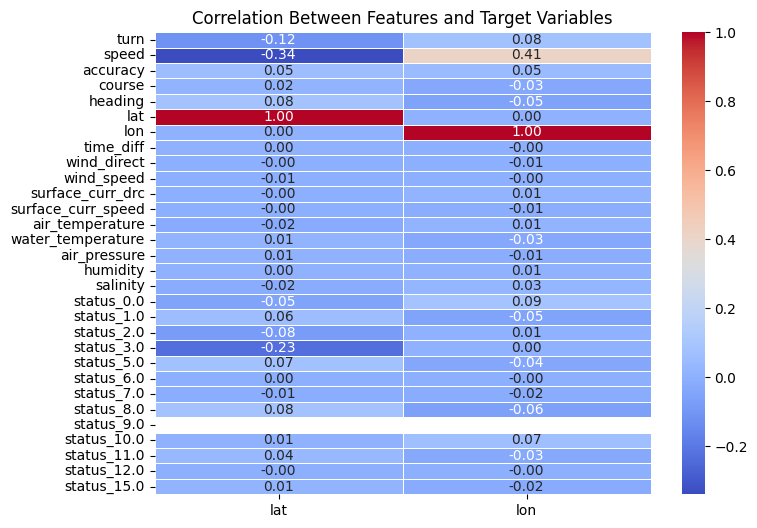

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# 독립 변수와 종속 변수(`lat`, `lon`) 간의 상관관계 행렬 계산
corr_matrix = data[selected_columns].corr()

# 종속 변수(`lat`, `lon`)와만 상관관계 확인
corr_target = corr_matrix[target_columns]  # 타겟 변수와의 상관관계 추출

# 히트맵 시각화
plt.figure(figsize=(8,6))
sns.heatmap(corr_target, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Features and Target Variables")
plt.show()


In [3]:
# 타겟 변수와의 상관관계만 분석
target_corr = data[selected_columns].corrwith(data["lat"]).abs() + data[selected_columns].corrwith(data["lon"]).abs()

# 상관관계가 너무 낮은 변수 찾기 (임계값: 0.05 이하)
low_corr_vars = target_corr[target_corr < 0.05].index.tolist()

print(f"타겟 변수와 상관관계가 낮은 변수들 (|correlation| < 0.05): {low_corr_vars}")


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


타겟 변수와 상관관계가 낮은 변수들 (|correlation| < 0.05): ['course', 'time_diff', 'wind_direct', 'wind_speed', 'surface_curr_drc', 'surface_curr_speed', 'air_temperature', 'water_temperature', 'air_pressure', 'humidity', 'salinity', 'status_6.0', 'status_7.0', 'status_12.0', 'status_15.0']


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [6]:
# 데이터 분할 (학습/테스트만 나누기)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train 데이터 크기: {X_train.shape}, {y_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}, {y_test.shape}")


Train 데이터 크기: (1330078, 5, 30), (1330078, 2)
Test 데이터 크기: (332520, 5, 30), (332520, 2)


In [7]:
# Tensor 변환 및 GPU로 이동
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterSampler

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력
        return out

# 하이퍼파라미터 샘플링 범위
param_dist = {
    'hidden_size': [32, 64, 96, 128, 192, 256, 384, 512, 768, 1024],  # 더 세밀한 값 추가
    'num_layers': [1, 2, 3, 4, 5, 6],  # 더 깊은 모델도 고려
    'learning_rate': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],  # 더 작은 & 큰 값 포함
    'batch_size': [16, 24, 32, 48, 64, 96, 128, 256],  # 더 다양한 배치 크기 추가
    'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # 더 다양한 드롭아웃 확률 추가
}

# 랜덤 샘플링
n_iter = 100
random_params = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# 랜덤 서치 실행
best_loss = float('inf')
best_params = None

for params in random_params:
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']

    # 모델 초기화
    model = LSTMModel(
        input_size=X_train.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=2,  # 5분, 10분, 30분 후 좌표 예측
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 배치 학습
    model.train()
    train_loss = 0.0
    num_batches = 0  # 배치 개수 추적

    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:min(i+batch_size, len(X_train_tensor))].to(device)
        y_batch = y_train_tensor[i:min(i+batch_size, len(y_train_tensor))].to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient Clipping 적용
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()
        num_batches += 1

    # 평균 손실 계산
    avg_loss = train_loss / num_batches  # 전체 배치 개수로 나눔
    print(f"Params: {params}, Loss: {avg_loss:.4f}")

    # 최적 파라미터 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"최적 파라미터: {best_params}, 손실: {best_loss:.4f}")


Using device: cuda
Params: {'num_layers': 4, 'learning_rate': 1e-05, 'hidden_size': 384, 'dropout': 0.1, 'batch_size': 128}, Loss: 1.2733
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.7578
Params: {'num_layers': 3, 'learning_rate': 0.0005, 'hidden_size': 768, 'dropout': 0.0, 'batch_size': 32}, Loss: 2.5807
Params: {'num_layers': 1, 'learning_rate': 0.05, 'hidden_size': 192, 'dropout': 0.4, 'batch_size': 64}, Loss: 2.2350
Params: {'num_layers': 5, 'learning_rate': 0.005, 'hidden_size': 768, 'dropout': 0.2, 'batch_size': 64}, Loss: 2.9996
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 1024, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.4220
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 64, 'dropout': 0.4, 'batch_size': 128}, Loss: 0.9948
Params: {'num_layers': 5, 'learning_rate': 0.0005, 'hidden_size': 256, 'dropout': 0.4, 'batch_size': 24}, Loss: 2.3815
Params: {'num_layers': 6, 'learni

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 손실 그래프를 그리는 함수
def plot_loss(train_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid()
    plt.show()

# 최적 파라미터
best_params = {'num_layers': 1, 'learning_rate': 0.0005, 'hidden_size': 96, 'dropout': 0.3, 'batch_size': 32}

# 모델 정의
best_model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=2,
    dropout=best_params['dropout']
).to(device)

criterion = nn.SmoothL1Loss()

# 첫 번째 단계 학습 (High Learning Rate)
initial_lr = best_params['learning_rate']
optimizer = optim.Adam(best_model.parameters(), lr=initial_lr)

print("Stage 1: High Learning Rate Training")
num_epochs_stage1 = 100

train_losses = []  # 손실값 저장 리스트

for epoch in range(num_epochs_stage1):
    train_loss = 0.0
    num_batches = 0  # 배치 개수 추적
    best_model.train()

    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:min(i+best_params['batch_size'], len(X_train_tensor))].to(device)
        y_batch = y_train_tensor[i:min(i+best_params['batch_size'], len(y_train_tensor))].to(device)

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient Clipping 적용
        torch.nn.utils.clip_grad_norm_(best_model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()
        num_batches += 1

    avg_loss = train_loss / num_batches
    train_losses.append(avg_loss)
    print(f"Stage 1 - Epoch [{epoch+1}/{num_epochs_stage1}], Loss: {avg_loss:.4f}")



c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Stage 1: High Learning Rate Training
Stage 1 - Epoch [1/100], Loss: 0.0679
Stage 1 - Epoch [2/100], Loss: 0.0156
Stage 1 - Epoch [3/100], Loss: 0.0125
Stage 1 - Epoch [4/100], Loss: 0.0109
Stage 1 - Epoch [5/100], Loss: 0.0099
Stage 1 - Epoch [6/100], Loss: 0.0097
Stage 1 - Epoch [7/100], Loss: 0.0093
Stage 1 - Epoch [8/100], Loss: 0.0086
Stage 1 - Epoch [9/100], Loss: 0.0087
Stage 1 - Epoch [10/100], Loss: 0.0086
Stage 1 - Epoch [11/100], Loss: 0.0086
Stage 1 - Epoch [12/100], Loss: 0.0081
Stage 1 - Epoch [13/100], Loss: 0.0083
Stage 1 - Epoch [14/100], Loss: 0.0083
Stage 1 - Epoch [15/100], Loss: 0.0081
Stage 1 - Epoch [16/100], Loss: 0.0081
Stage 1 - Epoch [17/100], Loss: 0.0080
Stage 1 - Epoch [18/100], Loss: 0.0077
Stage 1 - Epoch [19/100], Loss: 0.0078
Stage 1 - Epoch [20/100], Loss: 0.0079
Stage 1 - Epoch [21/100], Loss: 0.0080
Stage 1 - Epoch [22/100], Loss: 0.0077
Stage 1 - Epoch [23/100], Loss: 0.0078
Stage 1 - Epoch [24/100], Loss: 0.0077
Stage 1 - Epoch [25/100], Loss: 0.00

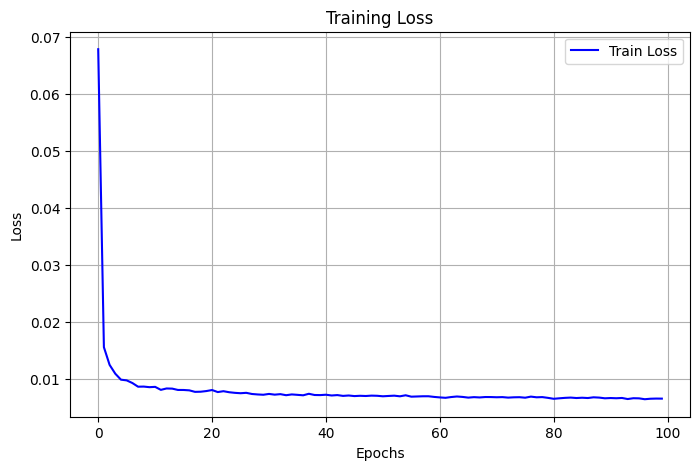

In [10]:

# 학습 후 손실 그래프 출력
plot_loss(train_losses)

In [11]:
# 두 번째 단계 학습 (Low Learning Rate)
new_lr = 0.00001 # 낮은 학습률로 조정 (기존 코드보다 더 낮게 조정)
optimizer = optim.Adam(best_model.parameters(), lr=new_lr)

# 학습률 감소 스케줄러 추가 (StepLR 사용)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print("\nStage 2: Low Learning Rate Training")
num_epochs_stage2 = 100

for epoch in range(num_epochs_stage2):
    train_loss = 0.0
    num_batches = 0
    best_model.train()

    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:min(i+best_params['batch_size'], len(X_train_tensor))].to(device)
        y_batch = y_train_tensor[i:min(i+best_params['batch_size'], len(y_train_tensor))].to(device)

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient Clipping 적용
        torch.nn.utils.clip_grad_norm_(best_model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()
        num_batches += 1

    avg_loss = train_loss / num_batches
    print(f"Stage 2 - Epoch [{epoch+1}/{num_epochs_stage2}],` Loss: {avg_loss:.4f}")

    # 학습률 감소
    scheduler.step()


Stage 2: Low Learning Rate Training
Stage 2 - Epoch [1/100],` Loss: 0.0059
Stage 2 - Epoch [2/100],` Loss: 0.0053
Stage 2 - Epoch [3/100],` Loss: 0.0051
Stage 2 - Epoch [4/100],` Loss: 0.0050
Stage 2 - Epoch [5/100],` Loss: 0.0049
Stage 2 - Epoch [6/100],` Loss: 0.0048
Stage 2 - Epoch [7/100],` Loss: 0.0048
Stage 2 - Epoch [8/100],` Loss: 0.0048
Stage 2 - Epoch [9/100],` Loss: 0.0047
Stage 2 - Epoch [10/100],` Loss: 0.0046
Stage 2 - Epoch [11/100],` Loss: 0.0046
Stage 2 - Epoch [12/100],` Loss: 0.0046
Stage 2 - Epoch [13/100],` Loss: 0.0046
Stage 2 - Epoch [14/100],` Loss: 0.0045
Stage 2 - Epoch [15/100],` Loss: 0.0045
Stage 2 - Epoch [16/100],` Loss: 0.0045
Stage 2 - Epoch [17/100],` Loss: 0.0045
Stage 2 - Epoch [18/100],` Loss: 0.0045
Stage 2 - Epoch [19/100],` Loss: 0.0045
Stage 2 - Epoch [20/100],` Loss: 0.0045
Stage 2 - Epoch [21/100],` Loss: 0.0044
Stage 2 - Epoch [22/100],` Loss: 0.0044
Stage 2 - Epoch [23/100],` Loss: 0.0044
Stage 2 - Epoch [24/100],` Loss: 0.0044
Stage 2 - Ep

In [12]:
best_model.eval()
test_loss = 0.0
y_pred = []  # 예측값 저장 리스트
y_true = y_test  # NumPy 배열 그대로 사용
num_batches = 0  # 배치 개수 추적

with torch.no_grad():
    for i in range(0, len(X_test_tensor), best_params['batch_size']):
        X_batch = X_test_tensor[i:min(i+best_params['batch_size'], len(X_test_tensor))].to(device)
        y_batch = y_test_tensor[i:min(i+best_params['batch_size'], len(y_test_tensor))].to(device)

        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        num_batches += 1

        # 결과 저장 (GPU -> CPU 변환 및 detach 사용)
        y_pred.append(outputs.detach().cpu().numpy())

# 예측값 변환
y_pred = np.concatenate(y_pred, axis=0)

# 평균 테스트 손실 계산
avg_test_loss = test_loss / num_batches  # 정확한 배치 개수로 나누기
print(f"테스트 손실(MSE): {avg_test_loss:.4f}")


테스트 손실(MSE): 0.0062


In [24]:
# 모델의 가중치 확인
print("✅ LSTM 모델 가중치 확인:")
for name, param in best_model.state_dict().items():
    print(f"{name}: {param.shape}")


✅ LSTM 모델 가중치 확인:
lstm.weight_ih_l0: torch.Size([384, 30])
lstm.weight_hh_l0: torch.Size([384, 96])
lstm.bias_ih_l0: torch.Size([384])
lstm.bias_hh_l0: torch.Size([384])
fc.weight: torch.Size([2, 96])
fc.bias: torch.Size([2])


In [21]:
torch.save(best_model, "lstm_model_v1.pth")
print("학습된 LSTM 모델이 lstm_model.pth 파일로 저장되었습니다!")


학습된 LSTM 모델이 lstm_model.pth 파일로 저장되었습니다!


In [25]:
torch.save(best_model.state_dict(), "lstm_model_v1weight.pth")  # 전체 모델이 아닌 가중치만 저장


In [13]:
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 예측 및 실제값을 비교하여 MAE, RMSE 및 R² 계산
def evaluate_model(model, X_test, y_test, batch_size=16):
    model.eval()  # 모델 평가 모드
    predictions = []
    true_values = []
    num_batches = 0  # 배치 개수 추적

    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            X_batch = X_test[i:min(i+batch_size, len(X_test))].to(device)  # 안전한 슬라이싱
            y_batch = y_test[i:min(i+batch_size, len(y_test))].to(device)

            outputs = model(X_batch)

            # GPU -> CPU 변환 및 detach() 적용
            predictions.append(outputs.detach().cpu().numpy())  
            true_values.append(y_batch.detach().cpu().numpy())

            num_batches += 1

    # NumPy 배열로 변환
    predictions = np.concatenate(predictions, axis=0)
    true_values = np.concatenate(true_values, axis=0)

    # MAE 계산
    mae = mean_absolute_error(true_values, predictions)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    # R² Score 계산
    r2 = r2_score(true_values, predictions)

    return mae, rmse, r2

# 평가 데이터에서 MAE, RMSE, R² 계산
mae, rmse, r2 = evaluate_model(best_model, X_test_tensor, y_test_tensor, batch_size=8)  # batch_size 조정

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE (Mean Absolute Error): 0.0164
RMSE (Root Mean Squared Error): 0.2040
R² Score: 0.9924


In [15]:
# 역스케일링
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

In [16]:
# 역스케일링
print(f"test크기:{y_test_original.shape}")
print(f"pred크기:{y_pred_original.shape}")


test크기:(332520, 2)
pred크기:(332520, 2)


In [17]:
comparison = pd.DataFrame({
    'True Lat': y_test_original[:, 0],
    'True Lon': y_test_original[:, 1],
    'Predicted Lat': y_pred_original[:, 0],
    'Predicted Lon': y_pred_original[:, 1]
})
print(comparison.head())

    True Lat    True Lon  Predicted Lat  Predicted Lon
0  35.109344  129.065445      35.109306     129.065445
1  35.109344  129.065445      35.109310     129.065445
2  35.109344  129.065445      35.109310     129.065445
3  35.109344  129.065460      35.109310     129.065445
4  35.109344  129.065460      35.109310     129.065445


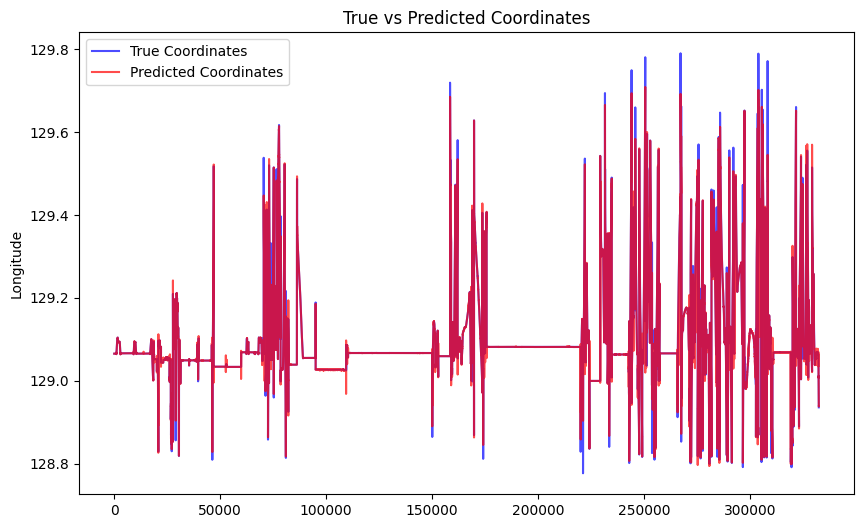

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(comparison['True Lon'])),comparison['True Lon'], label='True Coordinates', alpha=0.7, c='blue')
plt.plot(range(len(comparison['True Lon'])),comparison['Predicted Lon'], label='Predicted Coordinates', alpha=0.7, c='red')
plt.ylabel('Longitude')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.show()


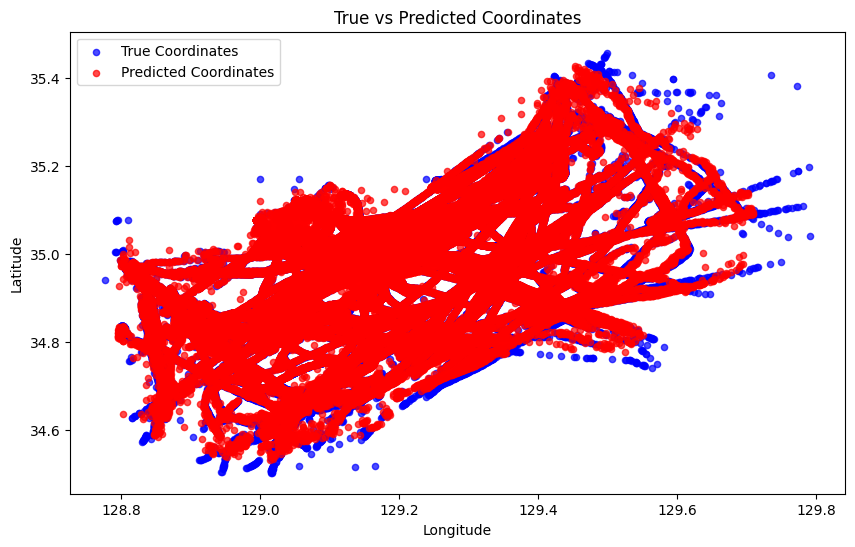

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(comparison['True Lon'], comparison['True Lat'], label='True Coordinates', alpha=0.7, c='blue', s=20)
plt.scatter(comparison['Predicted Lon'], comparison['Predicted Lat'], label='Predicted Coordinates', alpha=0.7, c='red', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn

# 예제 모델 정의
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

# 모델 생성 및 학습 후 저장
model = MyModel(input_size=30, output_size=2)

# 모델 저장 (가중치만 저장)
torch.save(model.state_dict(), "model2.pth")
print("모델 가중치가 model2.pth 파일로 저장되었습니다!")


모델 가중치가 model.pth 파일로 저장되었습니다!
